<h1> 현재 Pytorch 버전과 torchtext의 버전을 확인해주세요

- pytorch == 2.0.1
- torchtext == 0.15.2

버전 확인은 다음 코드를 통해 확인 가능합니다.

`import torch`

`print(torch.__version__)`

In [1]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.1.0+cu121
0.15.2+cpu


<h1> Transformer와 Torchtext를 활용한 번역기 만들기




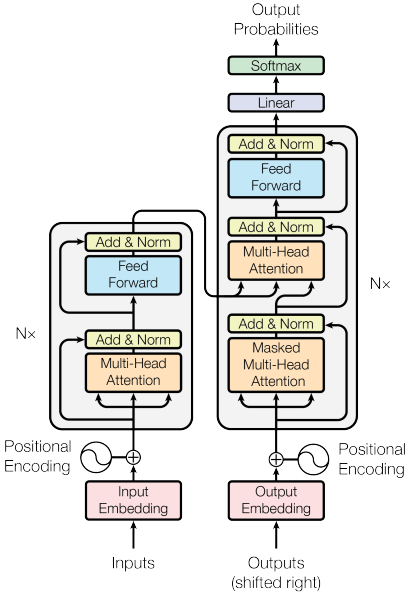

### 관련 라이브러리 설치

In [2]:
!pip install -U torchdata
!pip install -U spacy==3.6.0
!pip install portalocker # portallocker 패키지까지 설치해야 오류 발생하지 않음
!python -m spacy download en_core_web_lg # sm -> lg
!python -m spacy download de_core_news_lg # sm -> lg

2023-10-19 13:15:39.508936: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 13:15:40.591826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-19 13:15:41.999055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 13:15:41.999542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [3]:
# 번역 모델 학습에 필요한 도구 import

from torchtext.data.utils import get_tokenizer # 문장을 토큰화하기 위한 모듈
from torchtext.vocab import build_vocab_from_iterator # 단어집을 만들기 위한 모듈
from torchtext.datasets import multi30k, Multi30k # 데이터셋을 포함한 모듈
from typing import Iterable, List # 일부 데이터 타입을 선언하기 위한 모듈

- <h3> Multi30k에 존재하는 데이터 집합은 다음과 같습니다.

```
train
 (en) 29000 sentences, 377534 words, 13.0 words/sent
 (de) 29000 sentences, 360706 words, 12.4 words/sent
 (fr) 29000 sentences, 409845 words, 14.1 words/sent
 (cs) 29000 sentences, 297212 words, 10.2 words/sent
val
 (en) 1014 sentences, 13308 words, 13.1 words/sent
 (de) 1014 sentences, 12828 words, 12.7 words/sent
 (fr) 1014 sentences, 14381 words, 14.2 words/sent
 (cs) 1014 sentences, 10342 words, 10.2 words/sent
test_2016_flickr
 (en) 1000 sentences, 12968 words, 13.0 words/sent
 (de) 1000 sentences, 12103 words, 12.1 words/sent
 (fr) 1000 sentences, 13988 words, 14.0 words/sent
 (cs) 1000 sentences, 10497 words, 10.5 words/sent
test_2017_flickr
 (en) 1000 sentences, 11376 words, 11.4 words/sent
 (de) 1000 sentences, 10758 words, 10.8 words/sent
 (fr) 1000 sentences, 12596 words, 12.6 words/sent
test_2017_mscoco
 (en) 461 sentences, 5239 words, 11.4 words/sent
 (de) 461 sentences, 5158 words, 11.2 words/sent
 (fr) 461 sentences, 5710 words, 12.4 words/sent
 ```

<h3> 현재 실습에서는 출발어를 독일어(de), 도착어를 영어(en)로 설정하여 Transformer 기반 Seq2Seq 학습 예제를 진행합니다.

In [4]:
# 학습에 사용할 데이터 집합 불러오기
# 기존 데이터의 링크가 변경되었기 때문에, multi30k의 URL을 수정하여야합니다.
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de' # 독일어로부터
TGT_LANGUAGE = 'en' # 영어로의 번역

# Place-holders
token_transform = {}
vocab_transform = {}

<h3> 토크나이저 생성

텍스트 분석, 개체명 인식, 품사 태깅, 의존 구문 분석이 가능한 spacy에서 언어 모델을 불러옴

참고 : https://spacy.io/models

In [5]:
# 토크나이저 생성
# Spacy 라이브러리 내 언어모델 (de_core_news_sm, en_core_web_sm)의 토크나이저 활용
# I am a robot -> [i, am, a, robot]
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_lg') # sm -> lg
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_lg') # sm -> lg

In [6]:
# 토큰 목록을 생성해주는 함수. 즉 문자열을 받은 뒤 토큰화하여 반환해줌
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

- 언어 모델에서는 특수 토큰들을 사용
- 각 특수 토큰은 목적이 다름


In [7]:
# 특수 기호(symbol)와 인덱스를 정의
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # 학습용 데이터 반복자(iterator)
    # Multi30k 데이터셋에서 언어 쌍에 해당하는 데이터를 로드
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

    # 언어별로 어휘 집합을 구축
    # 데이터 집합 내 존재하는 토큰을 기준으로 어휘집 생성
    # min_freq : 토큰에 포함되는 최소 빈도 수. 1로 설정하면 모든 토큰을 포함하겠다는 의미
    # specials : 특수 토큰 목록
    # special_first를 True로 설정하여 특수 토큰이 어휘 집합의 처음에 오도록 설정
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

In [8]:
# ``UNK_IDX`` 를 기본 인덱스로 설정. 이 인덱스는 토큰을 찾지 못하는 경우에 반환
# 만약 기본 인덱스를 설정하지 않으면 어휘집(Vocabulary)에서 토큰을 찾지 못하는 경우
# ``RuntimeError`` 가 발생.
# 즉, 어휘집(Vocabulary)에서 토큰을 찾지 못하는 경우 Unknown Token으로 처리하기 위해 기본 인덱스를 지정

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

## `Transformer` 를 이용한 Seq2Seq 신경망

- 모델 선언과 학습에 필요한 모듈 import

In [9]:
import torch
import torch.nn as nn
import math
from torch import Tensor

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 학습을 진행할 장비 설정

In [10]:
print(DEVICE) # cuda 출력 확인. cpu로 되어있다면 런타임 유형 변경에서 하드웨어 가속 중 GPU 선택

cuda


- 가장 먼저 모든 입력은 다음 과정을 거친 뒤 본격적으로 신경망에 입력됨
1. 입력 임베딩
2. 위치 인코딩

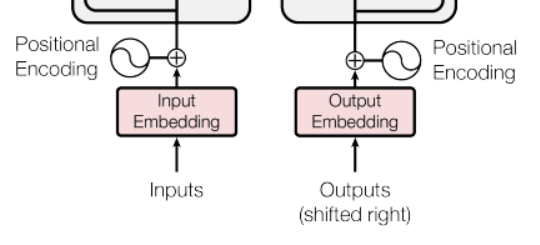

<h3> Token Embedding

In [11]:
# 입력 인덱스의 텐서를 해당하는 토큰 임베딩의 텐서로 변환. 즉, 입력 토큰을 텐서로 변환해주는 것
# vocab_size : 어휘 집 크기
# math.sqrt : 임베딩 벡터의 각 차원의 값이 너무 크지 않고, 너무 작지 않도록 만들어주는 역할

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

### Positional Encoding

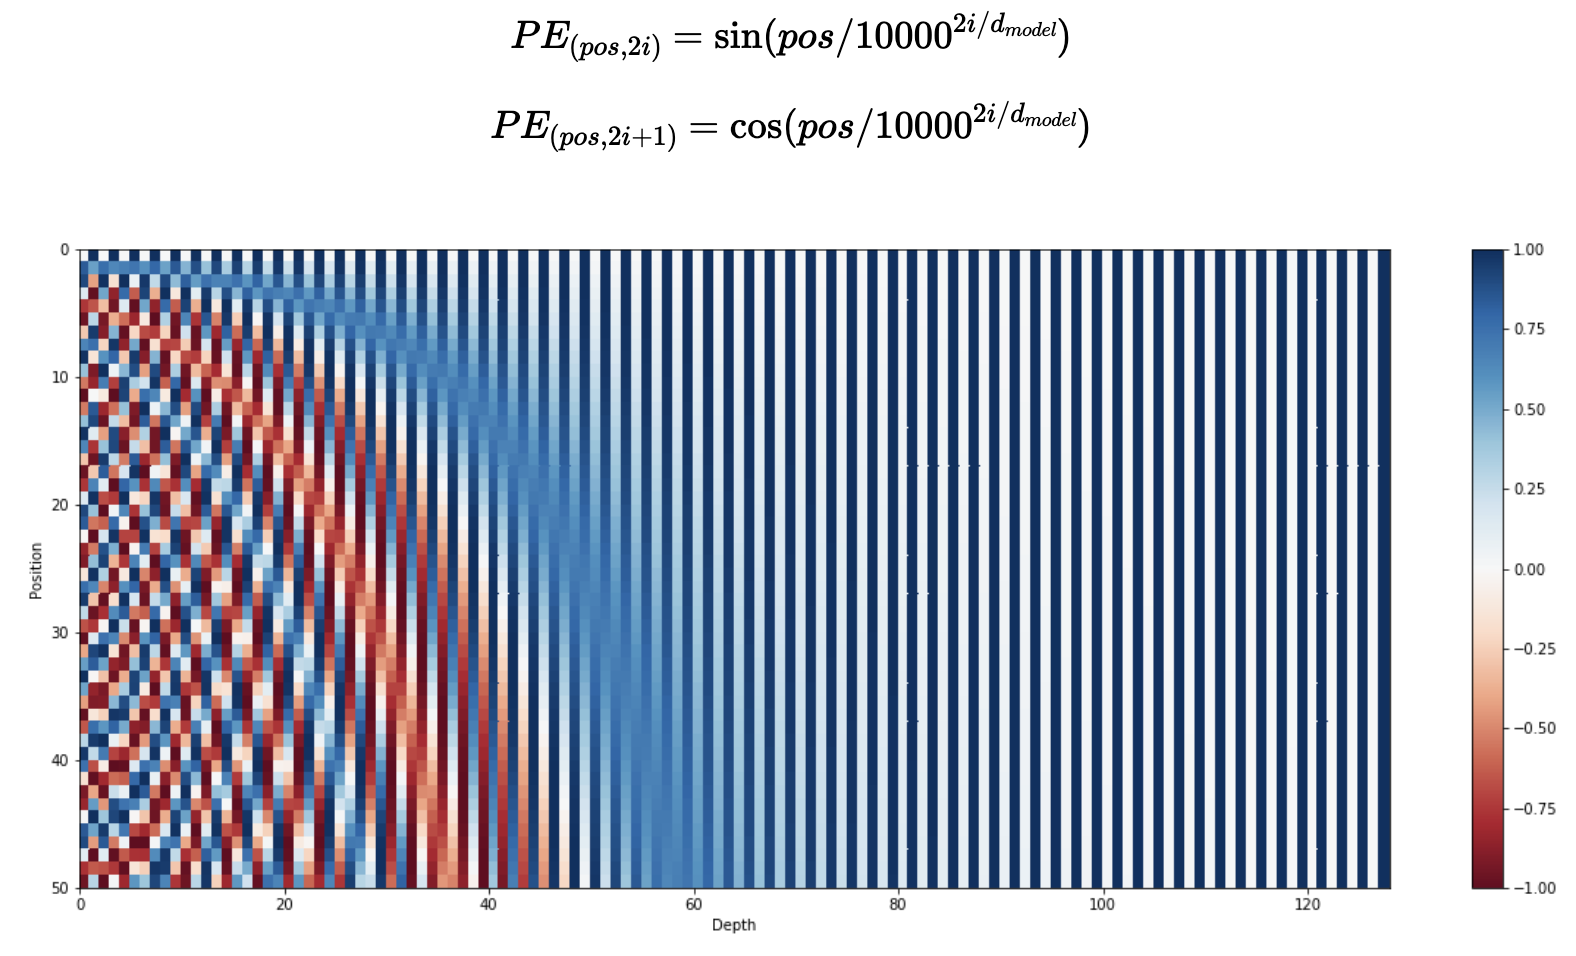

In [12]:
# 단어 간 순서 개념을 토큰 임베딩 과정에 적용하기 위해 Poisitional Encoding)
# RNN 기반의 신경망 모델들은 순차적인 입력을 통해 암묵적으로 시퀀스의 순서 정보 학습
# 트랜스포머의 경우 병렬적으로 모든 시점이 동시에 입력 -> 순서 정보를 포함하는 작업이 필요.
# 사인(sin)과 코사인(cos) 함수를 이용하여 서로 다른 위치의 토큰들에 대해 고유한 위치 인코딩을 생성가능
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den) # 0부터 시작하여 2씩 증가
        pos_embedding[:, 1::2] = torch.cos(pos * den) # 1부터 시작하여 2씩 증가
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor): # 임베딩된 토큰에 positional encoding
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

### Transformer Encoder

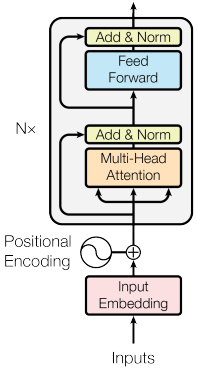

In [13]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim, # embed_size 크기
                 n_layers, # 인코더 레이어의 수
                 n_heads,  # 멀티 헤드 개수
                 pf_dim, # 피드포워드 신경망 크기 (embed_size)
                 dropout, # dropout 비율
                 device, # 사용할 장치
                 max_length = 100):
        super().__init__()

        self.device = device # device는 모두 cuda로 선언 되어있습니다.

        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)]) # N개의 layer를 생성

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        for layer in self.layers:
            src = layer(src, src_mask)

        # src = [batch size, src len, hid dim]

        return src

<h1> Encoder

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        # 멀티헤드 어텐션
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout,
                                                      device)

        # 멀티헤드 어텐션 이후 LayerNorm 부분
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        # 피드 포워드 신경망
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)

        # 피드 포워드 이후 LayerNorm
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        # positionwise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src = [batch size, src len, hid dim]

        return src

<h3> Multi-Head Attention Layer

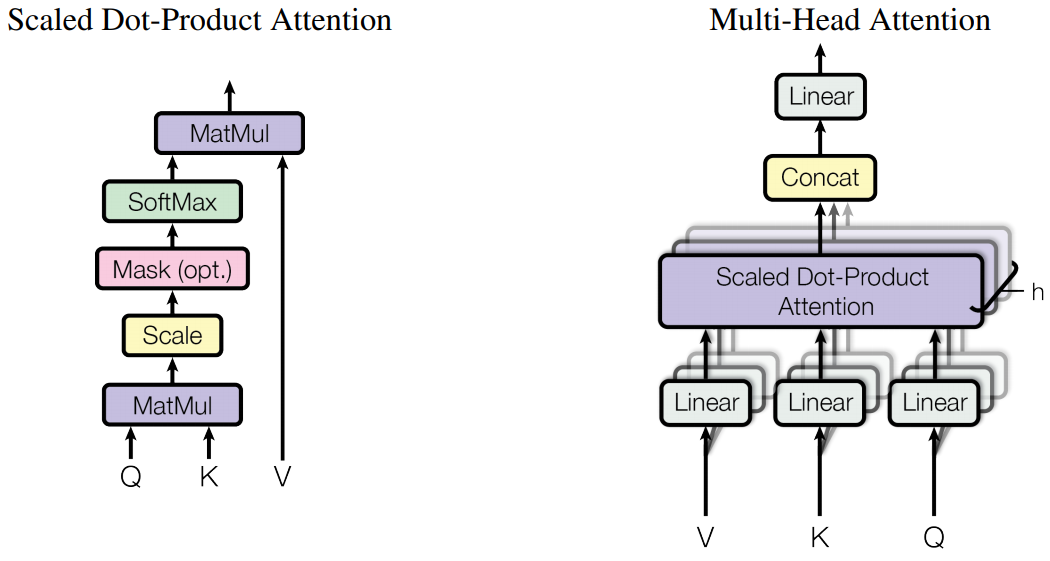

In [15]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]


        # Multi-Head로 분할하기 위해 view와 permute 연산 수행
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]

# [batch size, n heads, query len, head dim] X [batch size, n heads, head dim, key len]

        # Scaled Dot-product Attention
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy = [batch size, n heads, query len, key len]

        # 트랜스포머는 병렬적으로 입력을 처리함. 따라서 미래 시점에 관해서 가려줄 필요가 있음
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)

        # attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)

        # x = [batch size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x = [batch size, query len, n heads, head dim]

        # Multi-Head 연산의 결과를 다시 합쳐주는 곳.
        # Concat을 view 메서드로 구현
        x = x.view(batch_size, -1, self.hid_dim)

        # x = [batch size, query len, hid dim]

        x = self.fc_o(x)

        # x = [batch size, query len, hid dim]

        return x, attention

In [16]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # 사실 단순히 두 선형층으로 구성
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        # x = [batch size, seq len, hid dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x = [batch size, seq len, pf dim]

        x = self.fc_2(x)

        # x = [batch size, seq len, hid dim]

        return x

<h1> Decoder

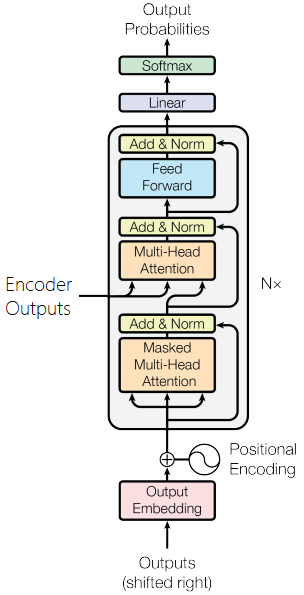

In [17]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # batch_size = trg.shape[0]
        # trg_len = trg.shape[1]

        # pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos = [batch size, trg len]

        # trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg = [batch size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]

        output = self.fc_out(trg)

        # output = [batch size, trg len, output dim]

        return output, attention

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]

        # encoder-decoder attention
        # key와 value가 encoder 로부터 들어온 것을 알 수 있는 부분
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg = [batch size, trg len, hid dim]
        # attention = [batch size, n heads, trg len, src len]

        return trg, attention

<h3> Seq2Seq Transformer 정의

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 emb_size,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 dropout,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.src_vocab_size = input_size
        self.tgt_vocab_size = output_size

        self.src_tok_emb = TokenEmbedding(self.src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(self.tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def make_src_mask(self, src):

        # src = [batch size, src len]
        # 패딩된 인덱스에 마스킹

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        # 패딩된 인덱스와 미래시점에 대한 마스킹
        # trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()


        # trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, tgt):

        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_trg_mask(tgt)

        # 입력 임베딩 및 위치 인코딩
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))

        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src_emb, src_mask)

        # enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(tgt_emb, enc_src, tgt_mask, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]

        return output, attention

In [20]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])

# 아래는 훈련에 필요한 하이퍼파라미터
HID_DIM = 1024 # == embed_size 512->1024
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

BATCH_SIZE = 64
LR = 0.00008 # 0.0001 -> 0.00007 -> 0.00008
NUM_EPOCHS = 12 # 10 -> 14

In [21]:
enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              DEVICE)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              DEVICE)

In [22]:
SRC_PAD_IDX = 1 # 둘 다 1
TRG_PAD_IDX = 1 # 얘도 1

In [23]:
torch.manual_seed(0)

# 모델 선언
transformer = Seq2Seq(INPUT_DIM, OUTPUT_DIM, HID_DIM, enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, 0.1, DEVICE).to(DEVICE)

# 모델의 가중치 초기화
for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

# 패딩한 부분의 인덱스도 오차에 포함하면 안되기 때문에 제외
# 단어가 등장할 확률 분포를 구하는 것이기 때문에
# 분포 간 오차를 구하기 위해 CrossEntropyLoss를 사용하는 것. softmax 함수 내장
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# 대부분 트랜스포머 신경망의 최적화 함수로, Adam Optimizer 사용
optimizer = torch.optim.Adam(transformer.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)


In [24]:
from torch.nn.utils.rnn import pad_sequence

# 순차적인 작업들을 하나로 묶는 헬퍼 함수
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# BOS/EOS를 추가하고 입력 순서(sequence) 인덱스에 대한 텐서를 생성하는 함수
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

In [25]:
# 출발어(src)와 도착어(tgt) 원시 문자열들을 텐서 인덱스로 변환하는 변형(transform)
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # 토큰화(Tokenization)
                                               vocab_transform[ln], # 수치화(Numericalization)
                                               tensor_transform) # BOS/EOS를 추가하고 텐서를 생성

In [26]:
# 데이터를 텐서로 조합(collate)하는 함수
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [27]:
from torch.utils.data import DataLoader

# 학습
def train_epoch(model, optimizer):
    model.train() # train 모드로 변환 필요
    losses = 0 # 초기 Loss
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE).permute(1, 0) # 배치 차원을 가장 앞으로 변환
        tgt = tgt.to(DEVICE).permute(1, 0)

        tgt_input = tgt[:,:-1]

        output, _ = model(src, tgt_input)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        optimizer.zero_grad()

        loss = loss_fn(output, tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()

    return losses / len(list(train_dataloader))

# 검증
def evaluate(model):
    model.eval()
    losses = 0

    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE).permute(1, 0)

        # tgt = [<sos>, x1, x2, ..., xn, <eos>]
        tgt = tgt.to(DEVICE).permute(1, 0)

        # tgt_input = [<sos>, x1, x2, ..., xn]
        tgt_input = tgt[:,:-1]

        # output = [y1, y2, ..., yn, <eos>]
        output, _ = model(src, tgt_input)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:,1:].contiguous().view(-1)

        # output     = [y1, y2, ..., yn, <eos>]
        # tgt[:, 1:] = [x1, x2, ..., xn, <eos>]
        loss = loss_fn(output, tgt)
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [28]:
from timeit import default_timer as timer

for epoch in range(1, NUM_EPOCHS+1): # 10 epoch 기준, 대략 8분 정도 소요
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/iter/combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


Epoch: 1, Train loss: 4.559, Val loss: 3.681, Epoch time = 96.211s
Epoch: 2, Train loss: 3.418, Val loss: 3.256, Epoch time = 93.375s
Epoch: 3, Train loss: 2.967, Val loss: 2.930, Epoch time = 94.778s
Epoch: 4, Train loss: 2.653, Val loss: 2.759, Epoch time = 95.904s
Epoch: 5, Train loss: 2.398, Val loss: 2.590, Epoch time = 94.532s
Epoch: 6, Train loss: 2.178, Val loss: 2.506, Epoch time = 96.696s
Epoch: 7, Train loss: 1.988, Val loss: 2.442, Epoch time = 94.665s
Epoch: 8, Train loss: 1.813, Val loss: 2.394, Epoch time = 95.026s
Epoch: 9, Train loss: 1.660, Val loss: 2.359, Epoch time = 96.415s
Epoch: 10, Train loss: 1.518, Val loss: 2.382, Epoch time = 94.440s
Epoch: 11, Train loss: 1.387, Val loss: 2.378, Epoch time = 94.285s
Epoch: 12, Train loss: 1.271, Val loss: 2.363, Epoch time = 94.221s


- 밑에 함수들은 실제 문장을 넣어보기 위한 도구 함수들

In [29]:
# 탐욕(greedy) 알고리즘을 사용하여 출력 순서(sequence)를 생성하는 함수
def greedy_decode(model, src, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = model.make_src_mask(src)
    src_emb = model.positional_encoding(transformer.src_tok_emb(src))

    memory = model.encoder(src_emb, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = model.make_trg_mask(ys.permute(1, 0))
        out, _ = transformer.decoder(transformer.positional_encoding(transformer.tgt_tok_emb(ys.permute(1, 0))), memory, tgt_mask, src_mask)
        _, next_word = torch.max(out[:, -1], dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

# 입력 문장을 도착어로 번역하는 함수
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(1, -1)
    num_tokens = src.shape[1]
    tgt_tokens = greedy_decode(
        model,  src, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [30]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))
# 원문 : 한 무리의 사람들이 이글루 앞에 서있다.
# 번역 : 한 무리의 사람들이 동상 앞에 서있다.

 A group of people standing in front of an ATM store . 


In [31]:
print(translate(transformer, "Es gibt viele Leute am Bahnhof."))
# 원문 : 기차역에 많은 사람들이 있다.
# 번역 : 사람들이 기차역에서 기다린다.

 A lot of people at night . 


<h1> TODO #1 모델의 성능 높이기

1. `Val loss`가 `2.400` 이하가 되도록 학습해보기.
2. 성능을 높인 후 `translate` 함수를 통해 결과가 달라지는 지 확인


Hint :
- 하이퍼 파라미터 변경
    - HID_DIM
    - ENC_LAYERS
    - DEC_LAYERS
    - ENC_HEADS
    - DEC_HEADS
    - ENC_PF_DIM
    - DEC_PF_DIM
    - ENC_DROPOUT
    - DEC_DROPOUT
    - BATCH_SIZE
    - LR
    - NUM_EPOCHS

- spacy 제공하는 언어 모델 변경
    - https://spacy.io/models

- 최적화 함수 변경

- 이외 다양한 학습 테크닉 적용 가능

<h2> TODO1

수정사항
1. spacy 언어 모델 변경

   en_core_web_sm -> en_core_web_lg

   de_core_news_sm -> de_core_news_lg

2. Parameter 변경
- HID_DIM : 512 -> 1024
- LR : 0.0001 -> 0.00007 -> 0.00008
- NUM_EPOCHS : 10 -> 12

결과
1. val loss -> 2.363

<h1> TODO #2 다른 번역 예시

1. `독일어`에서 `영어` 이외에 Multi30k에서 제공하는 다른 언어 사용.
2. 학습 과정에서 `Train loss, Val loss` 출력
3. `translate` 함수에 샘플 문장 넣고 출력

Hint :
- `fr` → `en` 또는 `cs` → `en` 등
